# Unsupervised Learning: Clustering Lab





In [1]:
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import arff
import pandas as pd
from sklearn.cluster import AgglomerativeClustering

## 1. (50%) Implement the k-means clustering algorithm and the HAC (Hierarchical Agglomerative Clustering) algorithm.

### 1.1.1 HAC

### Code requirements 
- HAC should support both single link and complete link options.
- HAC automatically generates all clusterings from n to 1.  To simplify the amount of output you may want to implement a mechanism to specify for which k values actual output will be generated.


---
The output should include the following:
- The number of clusters (k).
- The total SSE of the full clustering. 


For each cluster report include:


- The centroid id.
- The number of instances tied to that centroid. 
* The SSE of that cluster. (The sum squared error (SSE) of a single cluster is the sum of the squared euclidean distance of each cluster member to the cluster centroid.)
---
You only need to handle continuous features

In [2]:
class HACClustering(BaseEstimator,ClusterMixin):

    def __init__(self,k=3,link_type='single', normalize=True):
        self.link_type = link_type
        self.k = k
        self.cluster_sizes = np.array([])
        self.cluster_sse = np.array([])
        self.total_cluster_sse = np.array([])
        self.normalize = normalize
        
    def fit(self,X,y=None):
        if y is not None:
            X = np.c_[X, y]
        if self.normalize:
            X = self.normalize_X(X)
        link_distances = np.array([])
        centroids = np.copy(X[:self.k])
        num_clusters = X.shape[0]
        distances = np.array([np.linalg.norm(X - row, axis=1) for row in X])
        orig_distances = np.copy(distances)
        for i in range(len(orig_distances)):
            orig_distances[i,:i+1] = np.inf
                
        while num_clusters != self.k:
            link = self.link(distances)
            link_distances = np.append(link_distances, distances[link])
            distances = self.merge(link, distances)
            num_clusters -= 1
            
        self.calculate_clusters(link_distances, orig_distances, X)
        self.total_cluster_sse = np.sum(self.cluster_sse)
        return self
    
    def calculate_clusters(self, links, distances, X):
        row_tuples = np.array([])
        for link in links:
            row_tuples = np.append(row_tuples, np.where(distances == link))
        clusters = [[0] for i in range(len(distances))]
        for i in range(len(clusters)):
            clusters[i] = [i]
        for i in range(0, len(row_tuples), 2):
            row_1 = row_tuples[i]
            row_2 = row_tuples[i+1]
            for j in range(len(clusters)):
                if row_1 in clusters[j]:
                    clusters = self.modify_clusters(row_2, clusters, j)
                    break
                if row_2 in clusters[j]:
                    clusters = self.modify_clusters(row_1, clusters, j)
                    break    
        self.centroids = np.empty((0, X.shape[1]))
        for cluster in clusters:
            self.cluster_sizes = np.append(self.cluster_sizes, len(cluster))
            cluster_points = []
            for row in cluster:
                cluster_points.append(X[row])
            centroid = np.expand_dims(np.array(cluster_points).mean(0), axis=0)
            self.centroids = np.vstack((self.centroids, centroid))
            self.cluster_sse = np.append(self.cluster_sse, self.sse(centroid.flatten(), np.expand_dims(np.array(cluster_points), axis=0)))
    
    def modify_clusters(self, row, clusters, j):
        for k in range(len(clusters)):
            if row in clusters[k]:
                if isinstance(clusters[k], list):
                    clusters[j].extend(clusters[k])
                else:
                    clusters[j].append(clusters[k])
                clusters.pop(k)
                break
        return clusters
    
    
    def link(self, distances):
        d_copy = np.copy(distances)
        d_copy = np.where(d_copy==0, np.inf, d_copy)
        return np.unravel_index(d_copy.argmin(), d_copy.shape)
    
    def merge(self, link, distances):
        n = distances.shape[0]
        m = np.array([distances[link[0]], distances[link[1]]])
        if self.link_type == 'single':
            m = np.min(m, axis=0)
        else:
            m = np.max(m, axis=0)
        m = np.delete(m, m.argmin())
        m = np.delete(m, m.argmin())
        m = np.expand_dims(m, 0)
        distances = np.delete(distances, link, axis=0)
        distances = np.delete(distances, link, axis=1)
        distances = np.reshape(distances, (n-2, n-2))
        distances = np.c_[distances, m.T]
        m = np.expand_dims(np.append(m, 0),0)
        distances = np.r_[distances, m]
        return distances

    def sse(self, centroid, cluster):
        distance = np.array([np.linalg.norm(cluster - centroid, ord=2, axis=1)])
        distance_squared = np.square(distance)              
        return np.sum(distance_squared)

    def normalize_X(self, X):
        index = 0
        for col in X.T:
            X[:,index] = (col - col.min()) / (col.max() - col.min())
            index += 1
        return X
    
    def print_clusters(self):
        print("{:d}".format(self.k))
        print("{:.4f}\n".format(self.total_cluster_sse))
        for i, centroid in enumerate(self.centroids):
            print(np.array2string(centroid,precision=4,separator=","))
            print("{:.0f}".format(self.cluster_sizes[i]))
            print("{:.4f}\n".format(self.cluster_sse[i]))

### 1.1.2 Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff)


---
The dataset was modified to be a lot smaller. The last datapoint should be on line 359 or the point 0.585,0.46,0.185,0.922,0.3635,0.213,0.285,10. The remaining points should be commented out.



- Normalize Data
- K = 5
- Use the first k instances as the initial centroids
- Use 4 decimal places and DO NOT ROUND when reporting SSE and centroid values.


---
Solutions in files:

[Debug HAC Single.txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20HAC%20Single%20Link.txt)

[Debug HAC Complete.txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20HAC%20Complete%20Link.txt)

In [75]:
# Load debug data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff --output datasets.arff
data = arff.loadarff('datasets.arff')
df = pd.DataFrame(data[0])
np_data = np.array(df)
X = np_data[:,0:-1].astype(np.float64)
y = np_data[:, -1].astype(np.float64)

# Train on debug data, debug single
kmean = HACClustering(k=5, normalize=True)
kmean.fit(X, y)

# Print clusters
kmean.print_clusters()

# Debug complete
kmean = HACClustering(k=5, link_type='complete', normalize=True)
kmean.fit(X, y)

# Print clusters
kmean.print_clusters()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  187k  100  187k    0     0   609k      0 --:--:-- --:--:-- --:--:--  609k
5
54.4392

[0.599 ,0.5923,0.4915,0.2826,0.2682,0.2921,0.2316,0.3849]
195
54.3917

[0.9189,0.9438,0.7105,0.7016,0.759 ,0.7222,0.4472,0.8824]
1
0.0000

[1.    ,0.9831,0.8026,0.8343,0.6575,0.7825,0.9221,0.8824]
2
0.0475

[1.    ,0.9888,0.7895,1.    ,1.    ,0.8915,0.7186,0.5882]
1
0.0000

[0.9189,0.9888,0.8684,0.719 ,0.5797,0.7512,0.6432,0.9412]
1
0.0000

5
13.0824

[0.6544,0.649 ,0.5256,0.2879,0.2815,0.3057,0.2288,0.3911]
71
3.8232

[0.3661,0.3505,0.271 ,0.1008,0.1024,0.1058,0.0836,0.2116]
67
5.2786

[0.7622,0.7658,0.6759,0.4265,0.4016,0.4536,0.3376,0.5217]
38
1.4989

[0.8818,0.8904,0.7582,0.614 ,0.5433,0.5317,0.561 ,0.7794]
16
1.5328

[0.9471,0.934 ,0.8158,0.7457,0.6434,0.7944,0.6457,0.625 ]
8
0.9490



### 1.1.3 Evaluation

We will evaluate your model based on its print_clusters() output using [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff)

In [76]:
# Load evaluation data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff --output datasets.arff
data = arff.loadarff('datasets.arff')
df = pd.DataFrame(data[0])
np_data = np.array(df)
X = np_data[:,0:-1].astype(np.float64)
y = np_data[:, -1].astype(np.float64)

# Train on evaluation data
kmean = HACClustering(k=5, normalize=True)
kmean.fit(X,y)

# Print clusters
kmean.print_clusters()

# Evaluate complete
kmean = HACClustering(k=5, link_type='complete', normalize=True)
kmean.fit(X,y)

# Print clusters
kmean.print_clusters()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6392  100  6392    0     0  25365      0 --:--:-- --:--:-- --:--:-- 25365
5
22.4548

[0.3159,0.3648,0.5145,0.349 ,0.3338,0.3077,0.2868,0.    ]
67
10.0257

[0.2774,0.2597,1.    ,0.1224,0.4505,0.7549,0.129 ,0.    ]
1
0.0000

[0.3065,0.3333,0.6979,0.2792,0.3787,1.    ,0.2373,0.    ]
1
0.0000

[0.0884,0.1818,0.    ,0.145 ,0.1538,0.1245,0.    ,0.    ]
1
0.0000

[0.714 ,0.7588,0.5603,0.7028,0.6994,0.4864,0.7393,1.    ]
70
12.4291

5
15.6967

[0.3636,0.4107,0.5609,0.3857,0.3937,0.2808,0.3155,0.    ]
49
5.0209

[0.3471,0.3622,0.7897,0.279 ,0.441 ,0.8568,0.2234,0.    ]
3
0.2178

[0.1656,0.2226,0.3509,0.2328,0.152 ,0.3424,0.1918,0.    ]
18
2.2794

[0.7918,0.8268,0.606 ,0.7669,0.7787,0.4634,0.7877,1.    ]
49
6.3712

[0.5326,0.6002,0.4536,0.5531,0.5144,0.5401,0.6266,1.    ]
21
1.8075



### 1.2.1 K-Means

### Code requirements 
- Ability to choose k and specify k initial centroids
- Use Euclidean Distance as metric
- Ability to handle distance ties
- Include output label as a cluster feature


---
The output should include the following:
- The number of clusters (k).
- The total SSE of the full clustering. 


For each cluster report include:


- The centroid id.
- The number of instances tied to that centroid. 
- The SSE of that cluster. (The sum squared error (SSE) of a single cluster is the sum of the squared euclidean distance of each cluster member to the cluster centroid.)
---
You only need to handle continuous features

In [29]:
class KMEANSClustering(BaseEstimator,ClusterMixin):

    def __init__(self,k=3,debug=False, normalize=True):
        self.k = k
        self.debug = debug
        self.cluster_sizes = np.array([])
        self.cluster_sse = np.array([])
        self.total_cluster_sse = np.array([])
        self.normalize = normalize

    def fit(self,X,y=None):
        if y is not None:
            X = np.c_[X, y]
        if self.normalize:
            X = self.normalize_X(X)
        if self.debug:
            centroids = np.copy(X[:self.k])
            old_centroids = np.zeros(centroids.shape)
        else:
            min_ = X.min(axis=0)
            max_ = X.max(axis=0)
            centroids = np.random.rand(self.k, X.shape[1])
            old_centroids = np.random.rand(self.k, X.shape[1])
        

        while np.sum(old_centroids-centroids) != 0:  
            old_centroids = np.copy(centroids)
            distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
            cluster = np.transpose(distances.argmin(axis=0)*np.ones((1,X.shape[0])))
            for i in range(self.k):
                current_cluster = np.where(cluster==i, 1, 0)
                if sum(current_cluster) > 0:
                    centroids[i] = np.sum(X*current_cluster, axis=0)/np.sum(current_cluster)
                    
        self.centroids = centroids
        for i in range(self.k):
            self.cluster_sizes = np.append(self.cluster_sizes, (cluster == i).sum())
        for i in range(self.k):
            current_cluster = X * np.where(cluster==i, 1, 0)
            current_cluster = current_cluster[~np.all(current_cluster == 0, axis=1)]
            self.cluster_sse = np.append(self.cluster_sse, self.sse(centroids[i], current_cluster))
        self.total_cluster_sse = np.sum(self.cluster_sse)
        return self
    
    def sse(self, centroid, cluster):
        distance = np.array([np.linalg.norm(cluster - centroid, ord=2, axis=1)])
        distance_squared = np.square(distance)              
        return np.sum(distance_squared)
    
    def normalize_X(self, X):
        index = 0
        for col in X.T:
            X[:,index] = (col - col.min()) / (col.max() - col.min())
            index += 1
        return X
    
    def print_clusters(self):
        print("{:d}".format(self.k))
        print("{:.4f}\n".format(np.sum(self.cluster_sse)))
        for i, centroid in enumerate(self.centroids):
            print(np.array2string(centroid,precision=4,separator=","))
            print("{:.0f}".format(self.cluster_sizes[i]))
            print("{:.4f}\n".format(self.cluster_sse[i]))



### 1.2.2 Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff)


- Train until convergence
- Normalize Data
- K = 5
- Use the first k instances as the initial centroids
- Use 4 decimal places and DO NOT ROUND when reporting SSE and centroid values


---
Solutions in files:

[Debug K Means.txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20K%20Means.txt)

In [77]:
# Load debug data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff --output datasets.arff
data = arff.loadarff('datasets/abalone.arff')
df = pd.DataFrame(data[0])
np_data = np.array(df)
X = np_data[:,0:-1].astype(np.float64)
y = np_data[:, -1].astype(np.float64)


# Train on debug data
kmean = KMEANSClustering(k=5, debug=True)
kmean.fit(X,y)

# Print clusters
kmean.print_clusters()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  187k  100  187k    0     0   628k      0 --:--:-- --:--:-- --:--:--  628k
5
9.7826

[0.7325,0.7327,0.627 ,0.3817,0.3633,0.4045,0.3046,0.4839]
75
4.0454

[0.3704,0.3519,0.2686,0.0926,0.0935,0.094 ,0.0792,0.218 ]
34
0.6609

[0.9035,0.905 ,0.7774,0.6579,0.5767,0.6193,0.5893,0.7279]
24
3.2116

[0.5692,0.5628,0.4376,0.211 ,0.2113,0.2248,0.1659,0.317 ]
54
1.5452

[0.1296,0.1037,0.1053,0.0177,0.0211,0.0272,0.0135,0.0724]
13
0.3195



### 1.2.3 Evaluation

We will evaluate your model based on its print_clusters() output using [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff)

In [78]:
# Load evaluation data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
np_data = np.array(df)
X = np_data[:,0:-1].astype(np.float64)
y = np_data[:, -1].astype(np.float64)

# Train on evaluation data
kmean = KMEANSClustering(k=5, debug=True)
kmean.fit(X,y)

# Print clusters
kmean.print_clusters()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6392  100  6392    0     0  11970      0 --:--:-- --:--:-- --:--:-- 11947
5
14.7279

[0.5349,0.6013,0.4617,0.5541,0.5232,0.5544,0.6248,1.    ]
22
2.0160

[0.3684,0.4338,0.4356,0.4388,0.3573,0.2988,0.3673,0.    ]
31
2.4076

[0.3658,0.3854,0.7563,0.3093,0.4659,0.3691,0.2413,0.    ]
20
2.5248

[0.1634,0.2137,0.3968,0.2178,0.1555,0.3078,0.1775,0.    ]
19
1.7770

[0.7961,0.831 ,0.6054,0.7709,0.7802,0.4553,0.7919,1.    ]
48
6.0025



## 2.1.1 (7.5%) Clustering the Iris Classification problem - HAC

Load the Iris Dataset [Iris Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff)

- Use single-link and complete link clustering algorithms
- State whether you normalize your data or not (your choice).  
- Show your results for clusterings using k = 2-7.  
- Graph the total SSE for each k and discuss your results (i.e. what kind of clusters are being made).
---

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7485  100  7485    0     0  22276      0 --:--:-- --:--:-- --:--:-- 22276


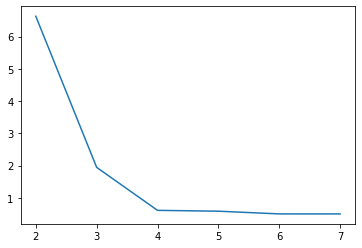

In [8]:
# Iris Classification using single-link
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
np_data = np.array(df)
X = np_data[:,0:-1].astype(np.float64)
# Evaluate complete
k_array = np.array([])
sse_array = np.array([])
for i in range(2,8):
    k_array = np.append(k_array, i)
    kmean = HACClustering(k=i, link_type='single', normalize=True)
    kmean.fit(X)
    sse_array = np.append(sse_array, kmean.total_cluster_sse)

plt.plot(k_array, sse_array)
plt.show()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7485  100  7485    0     0  30303      0 --:--:-- --:--:-- --:--:-- 30426


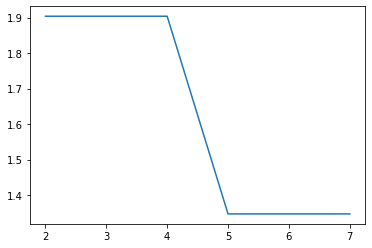

In [9]:
# Iris Classification using complete-link
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
np_data = np.array(df)
X = np_data[:,0:-1].astype(np.float64)
# Evaluate complete
k_array = np.array([])
sse_array = np.array([])
for i in range(2,8):
    k_array = np.append(k_array, i)
    kmean = HACClustering(k=i, link_type='complete', normalize=True)
    kmean.fit(X)
    sse_array = np.append(sse_array, kmean.total_cluster_sse)

plt.plot(k_array, sse_array)
plt.show()

Discuss differences between single-link and complete-link

Single link started off worse (over 6 SSE), but continually decreased until its SSE was under 1. 
Complete link stayed the same at around 2 clusters until getting to 5 clusters and then dropped to around 1.4. 
Single link did better because it found a lower floor for SSE.

## 2.1.2 (5%) Clustering the Iris Classification problem - HAC

Requirements:
- Repeat excercise 2.1.1 and include the output label as one of the input features.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7485  100  7485    0     0  80483      0 --:--:-- --:--:-- --:--:-- 80483


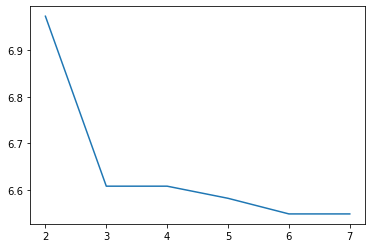

In [74]:
# Clustering Labels using single-link
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
np_data = np.array(df)
X = np_data[:,0:-1].astype(np.float64)
y = np.reshape([str(s.decode('utf-8')) for s in np_data[:,-1]], (-1, 1))

onehot_encoder = OneHotEncoder(sparse=False)
y = y.reshape(len(y), 1)
y = onehot_encoder.fit_transform(y)

k_array = np.array([])
sse_array = np.array([])
for i in range(2,8):
    k_array = np.append(k_array, i)
    kmean = HACClustering(k=i, link_type='single', normalize=True)
    kmean.fit(X,y)
    sse_array = np.append(sse_array, kmean.total_cluster_sse)

plt.plot(k_array, sse_array)
plt.show()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7485  100  7485    0     0  87034      0 --:--:-- --:--:-- --:--:-- 87034


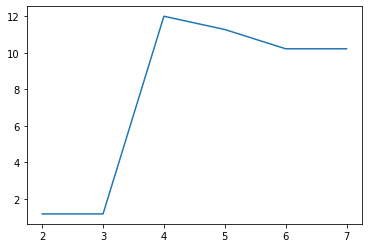

In [73]:
# Clustering Labels using complete-link
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
np_data = np.array(df)
X = np_data[:,0:-1].astype(np.float64)
y = np.reshape([str(s.decode('utf-8')) for s in np_data[:,-1]], (-1, 1))

onehot_encoder = OneHotEncoder(sparse=False)
y = y.reshape(len(y), 1)
y = onehot_encoder.fit_transform(y)

k_array = np.array([])
sse_array = np.array([])
for i in range(2,8):
    k_array = np.append(k_array, i)
    kmean = HACClustering(k=i, link_type='complete', normalize=True)
    kmean.fit(X,y)
    sse_array = np.append(sse_array, kmean.total_cluster_sse)

plt.plot(k_array, sse_array)
plt.show()

Discuss any differences between the results from 2.1.1 and 2.1.2.

Single link didn't have a big range, SSE stayed between 6.5 and 7. It did continually decrease over time. Complete linkage did vey well for 2 and 3 clusters, having an SSE under 2. However, it shot up after that. For this dataset at least, after creating more clusters than output classes performs poorly.

## 2.2.1 (7.5%) Clustering the Iris Classification problem: K-Means

Load the Iris Dataset [Iris Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff)

Run K-Means on the Iris dataset using the output label as a feature and without using the output label as a feature

Requirements:
- State whether you normalize your data or not (your choice).  
- Show your results for clusterings using k = 2-7.  
- Graph the total SSE for each k and discuss your results (i.e. what kind of clusters are being made).
---

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7485  100  7485    0     0  92407      0 --:--:-- --:--:-- --:--:-- 92407


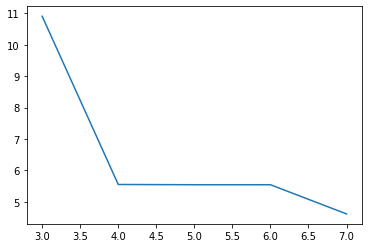

In [38]:
# Iris Classification without output label
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
np_data = np.array(df)
X = np_data[:,0:-1].astype(np.float64)

k_array = np.array([])
sse_array = np.array([])
for i in range(3,8):
    k_array = np.append(k_array, i)
    kmean = KMEANSClustering(k=i)
    kmean.fit(X)
    sse_array = np.append(sse_array, kmean.total_cluster_sse)

plt.plot(k_array, sse_array)
plt.show()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7485  100  7485    0     0      0      0 --:--:-- --:--:-- --:--:--     0    0  82252      0 --:--:-- --:--:-- --:--:-- 82252


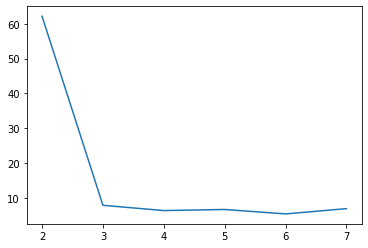

In [33]:
# Iris Classification with output label
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
np_data = np.array(df)
X = np_data[:,0:-1].astype(np.float64)
y = np.reshape([str(s.decode('utf-8')) for s in np_data[:,-1]], (-1, 1))

onehot_encoder = OneHotEncoder(sparse=False)
y = y.reshape(len(y), 1)
y = onehot_encoder.fit_transform(y)

k_array = np.array([])
sse_array = np.array([])
for i in range(2,8):
    k_array = np.append(k_array, i)
    kmean = KMEANSClustering(k=i)
    kmean.fit(X,y)
    sse_array = np.append(sse_array, kmean.total_cluster_sse)

plt.plot(k_array, sse_array)
plt.show()

Compare results and differences between using the output label and excluding the output label

Doing KMeans on the Iris dataset had a lot better performance without the output labels. Without the labels, it started out with an SSE of 11 and descended down to about 4. With output labels, it started extremely high at 60 but quickly plateued at around 8. I used one hot encoding to convert the output labels.

## 2.2.2 (5%) Clustering the Iris Classification problem: K-Means

Requirements:
- Use the output label as an input feature
- Run K-Means 5 times with k=4, each time with different initial random centroids and discuss any variations in the results. 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7485  100  7485    0     0  82252      0 --:--:-- --:--:-- --:--:-- 83166


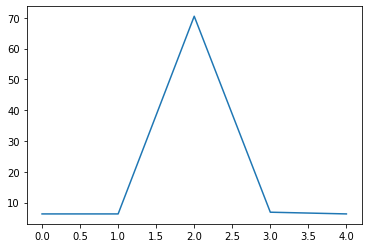

In [50]:
#K-Means 5 times
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
np_data = np.array(df)
X = np_data[:,0:-1].astype(np.float64)
y = np.reshape([str(s.decode('utf-8')) for s in np_data[:,-1]], (-1, 1))

onehot_encoder = OneHotEncoder(sparse=False)
y = y.reshape(len(y), 1)
y = onehot_encoder.fit_transform(y)

k_array = np.array([])
sse_array = np.array([])
for i in range(5):
    k_array = np.append(k_array, i)
    kmean = KMEANSClustering(k=4)
    kmean.fit(X,y)
    sse_array = np.append(sse_array, kmean.total_cluster_sse)

plt.plot(k_array, sse_array)
plt.show()

Discuss any variations in the results

It looks like the random values typically get the SSE below ten, but sometimes can lead to huge outliers. I think that it would be difficult to get an SSE much lower than the normal random run. The outlier skews the average.

## 3.1 (12.5%) Run the SK versions of HAC (both single and complete link) on iris including the output label and compare your results with those above.
Use the silhouette score for this iris problem(k = 2-7).  You may write your own code to do silhouette (optional extra credit) or you can use sklearn.metrics.silhouette_score. Please state if you coded your own silhouette score function to receive the extra credit points (described below). Discuss how helpful Silhouette appeared to be for selecting which clustering is best. You do not need to supply full Silhouette graphs, but you could if you wanted to.

Requirements
- Use the Sillhouette score for this iris problem (k= 2-7) 
- Use at least one other scoring function from [sklearn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) and compare the results. State which metric was used. 
- Possible sklean metrics include (* metrics require ground truth labels):
    - adjusted_mutual_info_score*
    - adjusted_rand_score*
    - homogeneity_score*
    - completeness_score*
    - fowlkes_mallows_score*
    - calinski_harabasz_score
    - davies_bouldin_score
- Experiment using different hyper-parameters. Discuss Results

The silhouette score sloped downwards, which made sense because there are only 3 output classes for the Iris dataset. It was surprising that 2 clusters worked a bit better than 3 for single linkage. The only parameter that I saw change anything was manhattan distance for complete linkage, which had better clustering scores, especially for 3 clusters.

The Calinski Harabaz score worked well for single and complete linkage and showed the best score for 3 clusterings, which was expected. There were no parameters to change for Calinski Harabaz.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7485  100  7485    0     0  83166      0 --:--:-- --:--:-- --:--:-- 83166


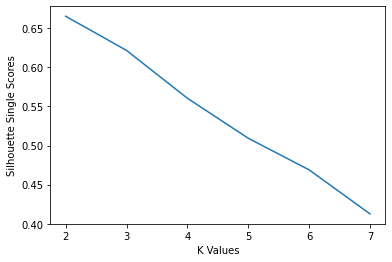

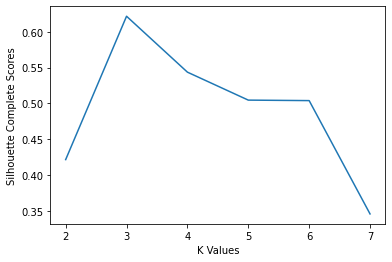

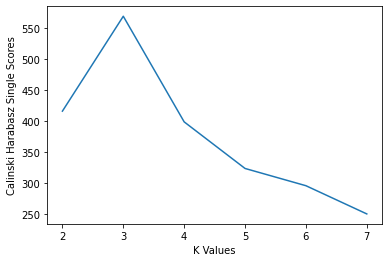

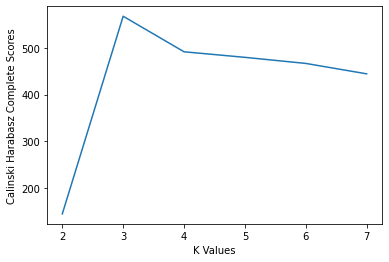

In [64]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
np_data = np.array(df)
X = np_data[:,0:-1].astype(np.float64)
y = np.reshape([str(s.decode('utf-8')) for s in np_data[:,-1]], (-1, 1))

onehot_encoder = OneHotEncoder(sparse=False)
y = y.reshape(len(y), 1)
y = onehot_encoder.fit_transform(y)
X = np.c_[X, y]

k_array = np.array([])
silhouette_single_scores = np.array([])
silhouette_complete_scores = np.array([])
ch_single_scores = np.array([])
ch_complete_scores = np.array([])
for i in range(2,8):
    k_array = np.append(k_array, i)
    clustering = AgglomerativeClustering(n_clusters=i, linkage='single').fit(X)
    sil_score = silhouette_score(X, clustering.labels_)
    ch_score = calinski_harabasz_score(X, clustering.labels_)
    silhouette_single_scores = np.append(silhouette_single_scores, sil_score)
    ch_single_scores = np.append(ch_single_scores, ch_score)
    clustering = AgglomerativeClustering(n_clusters=i, linkage='complete', affinity="manhattan").fit(X)
    sil_score = silhouette_score(X, clustering.labels_)
    ch_score = calinski_harabasz_score(X, clustering.labels_)
    silhouette_complete_scores = np.append(silhouette_complete_scores, sil_score)
    ch_complete_scores = np.append(ch_complete_scores, ch_score)

plt.xlabel('K Values')
plt.ylabel('Silhouette Single Scores')
plt.plot(k_array, silhouette_single_scores)
plt.show()

plt.xlabel('K Values')
plt.ylabel('Silhouette Complete Scores')
plt.plot(k_array, silhouette_complete_scores)
plt.show()

plt.xlabel('K Values')
plt.ylabel('Calinski Harabasz Single Scores')
plt.plot(k_array, ch_single_scores)
plt.show()

plt.xlabel('K Values')
plt.ylabel('Calinski Harabasz Complete Scores')
plt.plot(k_array, ch_complete_scores)
plt.show()

## 3.2 (12.5%) Run the SK version of k-means on iris including the output label and compare your results with those above. 

Use the silhouette score for this iris problem(k = 2-7). You may write your own code to do silhouette (optional extra credit) or you can use sklearn.metrics.silhouette_score. Please state if you coded your own silhouette score function to receive the extra credit points (described below). Discuss how helpful Silhouette appeared to be for selecting which clustering is best. You do not need to supply full Silhouette graphs, but you could if you wanted to.

Requirements
- Use the Sillhouette score for this iris problem (k= 2-7) 
- Use at least one other scoring function form sklearn.metrics and compare the results. State which metric was used
- Experiment different hyper-parameters. Discuss Results

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7485  100  7485    0     0  83166      0 --:--:-- --:--:-- --:--:-- 83166


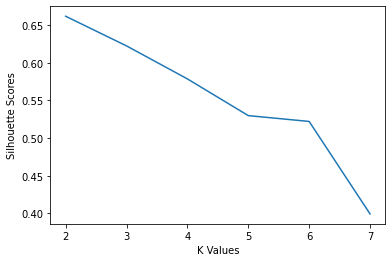

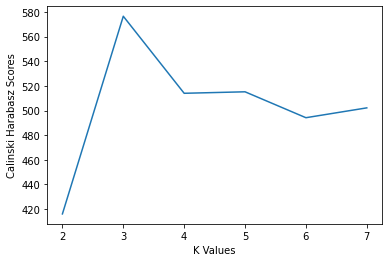

In [72]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
np_data = np.array(df)
X = np_data[:,0:-1].astype(np.float64)
y = np.reshape([str(s.decode('utf-8')) for s in np_data[:,-1]], (-1, 1))

onehot_encoder = OneHotEncoder(sparse=False)
y = y.reshape(len(y), 1)
y = onehot_encoder.fit_transform(y)
X = np.c_[X, y]

k_array = np.array([])
silhouette_scores = np.array([])
ch_scores = np.array([])
for i in range(2,8):
    k_array = np.append(k_array, i)
    clustering = KMeans(n_clusters=i).fit(X)
    sil_score = silhouette_score(X, clustering.labels_)
    ch_score = calinski_harabasz_score(X, clustering.labels_)
    silhouette_scores = np.append(silhouette_scores, sil_score)
    ch_scores = np.append(ch_scores, ch_score)
    
plt.xlabel('K Values')
plt.ylabel('Silhouette Scores')
plt.plot(k_array, silhouette_scores)
plt.show()

plt.xlabel('K Values')
plt.ylabel('Calinski Harabasz Scores')
plt.plot(k_array, ch_scores)
plt.show()


Again, it was interesting that the silhouette score was better for 2 clusters than 3. I tried different parameters but couldn't improve.

The Calinski Harabaz score worked well and showed the best score for 3 clusterings, which was expected. There were no parameters to change for Calinski Harabaz.

## 4. (Optional 5% extra credit) For your silhouette experiment above, write and use your own code to calculate the silhouette scores, rather than the SK or other version. 


*Show findings here*

In [17]:
# Copy function Below